In [ ]:
!pip3 install torch torchvision

In [ ]:
!pip3 install py7zr

In [ ]:
!pip3 install rasterio

In [4]:
import torch
import rasterio
import py7zr
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pycocotools.coco import COCO
from torch import nn
from torchvision import datasets, transforms, models

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

load dataset from github\
repo path : https://github.com/AnupamaRajkumar/LandfillDataset.git


In [6]:
!git clone https://github.com/AnupamaRajkumar/LandfillDataset.git

fatal: destination path 'LandfillDataset' already exists and is not an empty directory.


Extract the imaages from zip folder

In [7]:
def ExtractImages(in_path, out_path):
  with py7zr.SevenZipFile(in_path, mode='r') as z:
    z.extractall(out_path)

In [8]:
in_path = './LandfillDataset/HR_TIF_Files.7z'     #path of zip files
out_path = './'                                   #output path of extracted files
ExtractImages(in_path, out_path)

Displaying a few images from the folder

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of training images: 53
-------------multispectral images----------------
image :  00051_Vinca_Serbia.tif channels : 8
image :  00051_Vinca_Serbia.tif channels : 8
image :  00007_Erd_Hungary.tif channels : 8
image :  00048_Vinca_Serbia.tif channels : 8
image :  00012_Ersci_Hungary.tif channels : 8
image :  00006_Erd_Hungary.tif channels : 8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


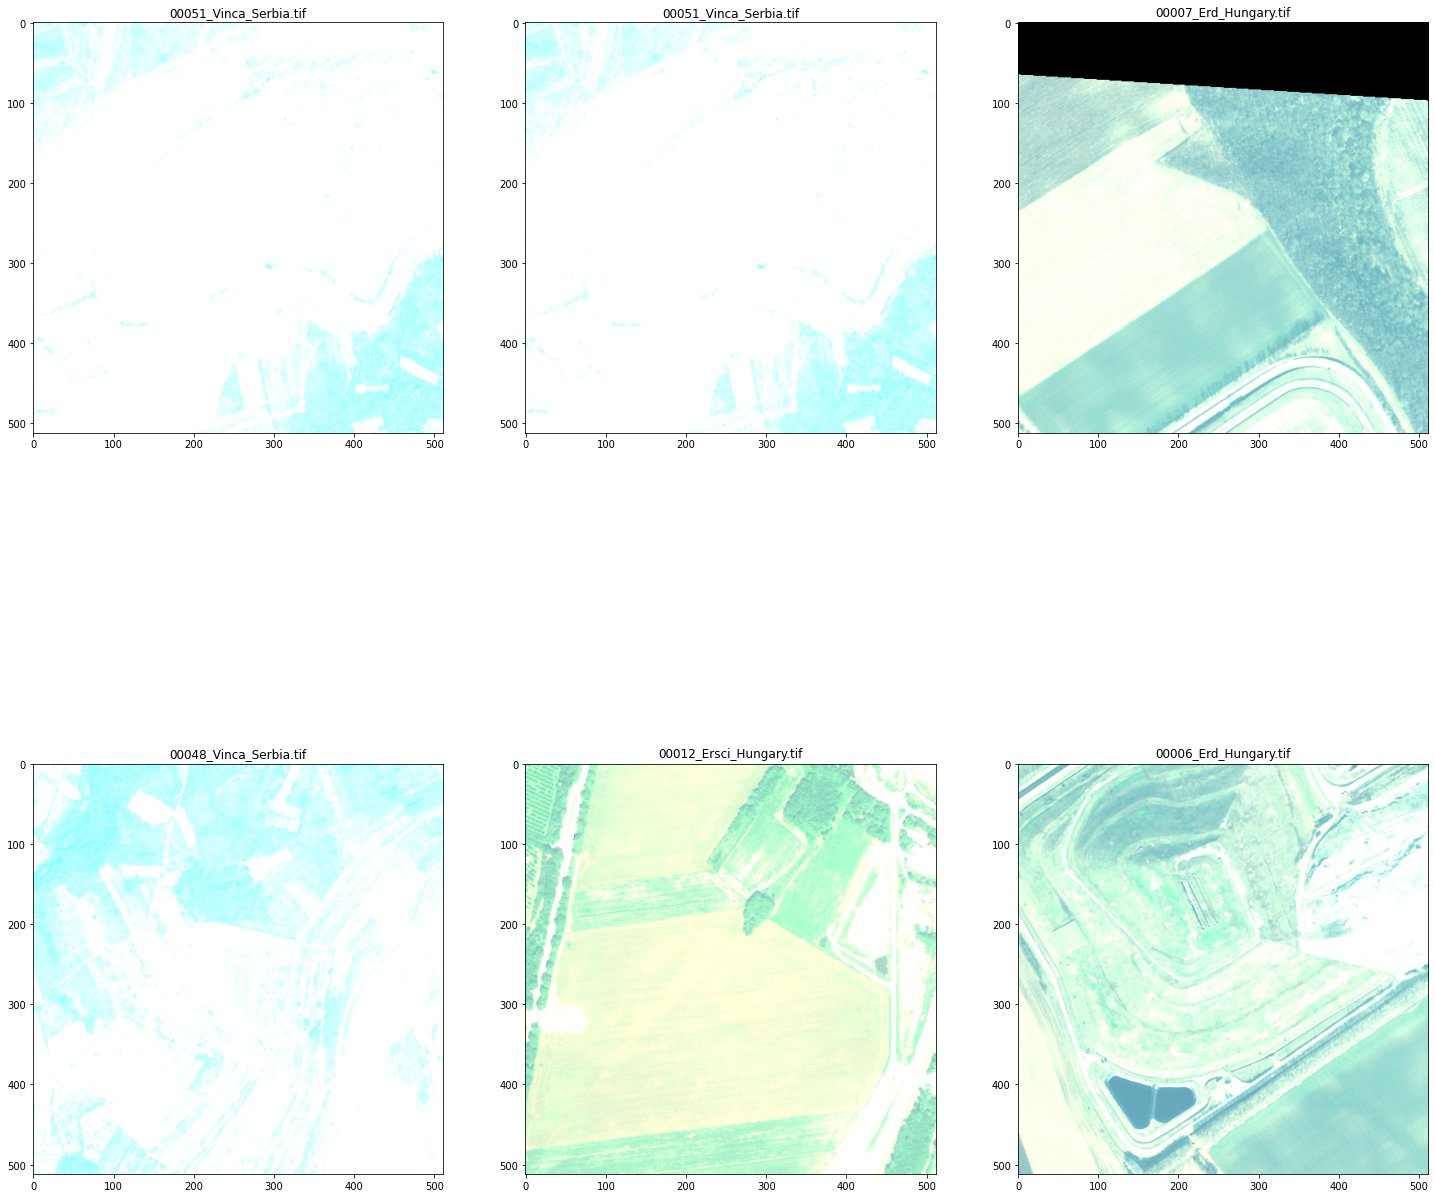

In [9]:
train_path = './HR_TIF_Files'
train_files = os.listdir(train_path)

num_of_train_images = len([name for name in train_files if os.path.isfile(os.path.join(train_path, name))])
print("Number of training images:", num_of_train_images)
selected = np.random.choice(num_of_train_images, 6)

fig = plt.figure(figsize = (25,25))
print('-------------multispectral images----------------')

for i, ind in enumerate(selected):
  raster = rasterio.open(os.path.join(train_path, train_files[ind]))
  raster_arr = raster.read()
  channels = raster_arr.shape[0]
  print("image : " , train_files[ind], "channels :", channels)
  #false color composite visualisation
  if(channels == 8):
    raster_fcc=np.dstack((raster_arr[4,:,:], raster_arr[2,:,:],raster_arr[1,:,:]))  
  elif(channels == 4):
    raster_fcc=np.dstack((raster_arr[2,:,:], raster_arr[1,:,:],raster_arr[0,:,:]))

  plt.subplot(2, 3, i+1)
  plt.imshow(raster_fcc)
  plt.title(train_files[ind])

Loading a dataset in COCO format

referred from:\
https://github.com/tkshnkmr/frcnn_medium_sample,
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [10]:
train_labels = './LandfillDataset/LandfillTrainingDataset.json'

In [45]:
from rasterio.plot import reshape_as_raster, reshape_as_image

class CustomLandfillDataset(torch.utils.data.Dataset):
  def __init__(self, data, annotations, transforms=None):
    self.data = data
    self.labels = COCO(annotations)
    self.transforms = transforms
    self.ids = list(sorted(self.labels.imgs.keys()))

  def __len__(self):
    return len(self.ids)

  def __getitem__(self, index):
    #annotations
    label = self.labels
    #image id
    img_id = self.ids[index]
    #path for image
    img_name = label.loadImgs(img_id)[0]["file_name"]
    #read the image
    raster_img = rasterio.open(os.path.join(train_path, img_name)).read()
    raster_channels = raster_img.shape[0]
    #convert raster to numpy array
    img_numpy = np.array(raster_img, dtype=np.int16)
    #image details
    img_info = {}
    img_info["image_id"] = img_id
    img_info["image_name"] = img_name
    img_info["raster_channels"] = raster_channels

    return img_info

In [46]:
#parameters
batch_size = 6
num_workers = 1

In [47]:
train_dataset = CustomLandfillDataset(data=train_path, annotations=train_labels, transforms=None)

#data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           num_workers=num_workers,
                                           shuffle=True)

print("length of training dataset:", len(train_dataset))
print("length of training loader:", len(train_loader))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
length of training dataset: 53
length of training loader: 9


Checking out some images and their corresponding masks

In [48]:
def im_convert(image_name, channels):
  image = rasterio.open(os.path.join(train_path, image_name)).read()
  #false color composite visualisation
  if(channels == 8):
    raster = np.dstack((image[4,:,:], image[2,:,:],image[1,:,:])) 
  elif(channels == 4):
    raster = np.dstack((image[2,:,:], image[1,:,:],image[0,:,:]))
  return raster

{'image_id': tensor([11, 22,  6, 31, 18, 53]), 'image_name': ['00011_Ersci_Hungary.tif', '00022_Abd_India.tif', '00006_Erd_Hungary.tif', '00031_Mumbai_India.tif', '00018_Hanover_Germany.tif', '00053_Vinca_Serbia.tif'], 'raster_channels': tensor([8, 4, 8, 4, 8, 8])}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


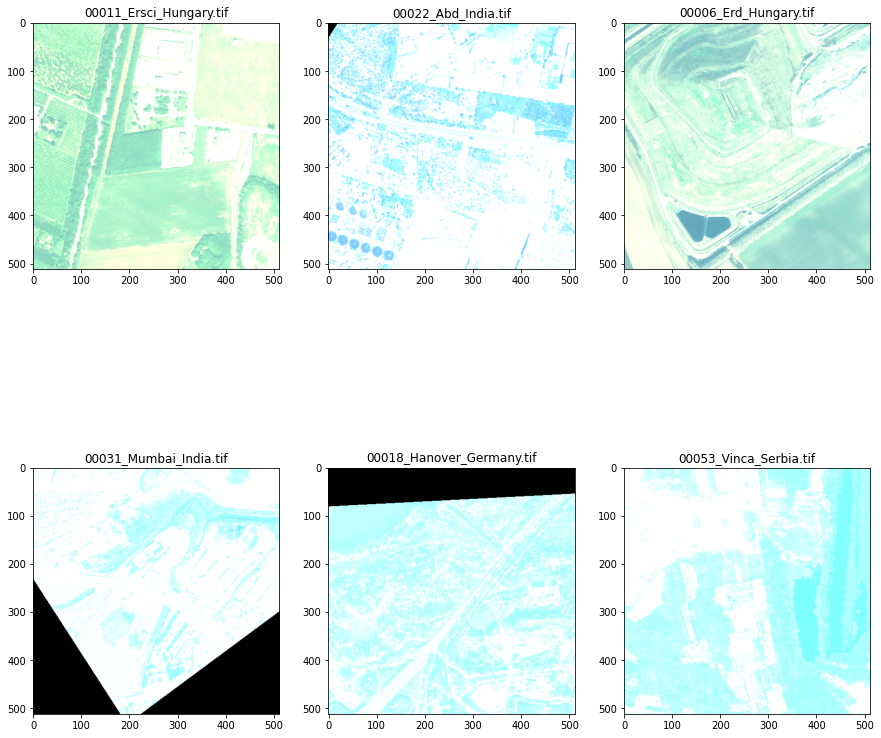

In [49]:
fig = plt.figure(figsize=(15,15))

img_info = next(iter(train_loader))
print(img_info)

for idx in np.arange(batch_size):
  plt.subplot(2, 3, idx+1)
  id = img_info["image_id"][idx].item()
  name = img_info["image_name"][idx]
  channels = img_info["raster_channels"][idx].item()
  plt.imshow(im_convert(name, channels))
  plt.title(name)

Custom transforms:\
https://pytorch.org/tutorials/recipes/recipes/custom_dataset_transforms_loader.html